# HW7 DATASCI W261: Machine Learning at Scale  
 
* **Name:**  Megan Jasek
* **Email:**  meganjasek@ischool.berkeley.edu
* **Class Name:**  W261-2
* **Week Number:**  9
* **Homework Number:**  7
* **Date:**  7/10/16

<h1 style="color:#021353;">General Description</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
In this assignment you will explore networks and develop MRJob code for 
finding shortest path graph distances. To build up to large data 
you will develop your code on some very simple, toy networks.
After this you will take your developed code forward and modify it and 
apply it to two larger datasets (performing EDA along the way).

<h3>Undirected toy network dataset</h3>


In an undirected network all links are symmetric, 
i.e., for a pair of nodes 'A' and 'B,' both of the links:

A -> B and B -> A

will exist. 

The toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/undirected_toy.txt
On under the Data Subfolder for HW7 on Dropbox with the same file name. 
The Data folder is in: https://db.tt/Kxu48mL1)

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


<h3>Directed toy network dataset</h3>

In a directed network all links are not necessarily symmetric, 
i.e., for a pair of nodes 'A' and 'B,' it is possible for only one of:

A -> B or B -> A

to exist. 

These toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/directed_toy.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).
</pre>
</div>

In [1]:
%%writefile directed_toy.txt
1	{'2': 1, '6': 1}
2	{'1': 1, '3': 1, '4': 1}
3	{'2': 1, '4': 1}
4	{'2': 1, '5': 1}
5	{'1': 1, '2': 1, '4': 1}

Overwriting directed_toy.txt


In [26]:
%%writefile d2_toy.txt
A	{'B': 1, 'E': 1000}
B	{'C': 1}
C	{'D': 1}
D	{'E': 1}
E	{'F': 1}

Overwriting d2_toy.txt


In [3]:
%%writefile d2a_toy.txt
A	{'B': 1, 'E': 4}
B	{'C': 1}
C	{'D': 1}
D	{'E': 1}
E	{'F': 1}

Writing d2a_toy.txt


In [30]:
%%writefile d3_toy.txt
A	{'B': 10, 'C': 5}
B	{'C': 2, 'D': 1}
C	{'B': 3, 'D': 9, 'E': 2}
D	{'E': 4}
E	{'A': 7, 'D': 6}

Writing d3_toy.txt


In [1]:
%%writefile d4_toy.txt
1	{"2": 1, "5": 100}
2	{"1": 1, "3": 1, "5": 1, "4": 1}
3	{"2": 1, "4": 1}
4	{"3": 1, "2": 1, "5": 1}
5	{"1": 100, "2": 1, "4": 1, "6":1}
6	{"5": 1, "7": 1}
7	{"6": 1}

Writing d4_toy.txt


In [2]:
%%writefile undirected_toy.txt
1	{'2': 1,'5': 1}
2	{'1': 1,'3': 1,'4': 1,'5': 1}
3	{'2': 1, '4': 1}
4	{'2': 1,'3': 1,'5': 1}
5	{'1': 1, '2': 1, '4': 1}

Overwriting undirected_toy.txt


<h1 style="color:#021353;">HW 7.0: Shortest path graph distances (toy networks)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, as described in the lectures. In addition to finding the distances, your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4. NOTE: There is another shortest path also (HINT: 1->5->4)! Either will suffice (you will find this also in the remaining problems. E.g., 7.2 and 7.4.
 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!

<h3>Main dataset 1: NLTK synonyms</h3>

In the next part of this assignment you will explore a network derived from the NLTK synonym database used for evaluation in HW 5. At a high level, this network is undirected, defined so that there exists link between two nodes/words if the pair or words are a synonym. These data may be found at the location:

<a href="s3://ucb-mids-mls-networks/synNet/synNet.txt">s3://ucb-mids-mls-networks/synNet/synNet.txt</a>
<a href="s3://ucb-mids-mls-networks/synNet/indices.txt">s3://ucb-mids-mls-networks/synNet/indices.txt</a>
On under the Data Subfolder for HW7 on Dropbox with the same file names

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

(word) \t (index)

of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).
</pre>
</div>

In [138]:
%%writefile SSSPInit.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class MRSSSPInit(MRJob):
    def configure_options(self):
        # Configure a new command line option to enable the job to accept the value
        # of k required by the Kmeans algorithm.
        super(MRSSSPInit, self).configure_options()
        self.add_passthrough_option('--start_index', type='str', default='1')
        self.add_passthrough_option('--unweighted', type='str', default='0')
        #self.add_passthrough_option('--num_maps', type='str', default='5')
        #self.add_passthrough_option('--num_reduces', type='str', default='1')
    
    def __init__(self, *args, **kwargs):
        super(MRSSSPInit, self).__init__(*args, **kwargs)
        self.start_index = self.options.start_index
        self.unweighted = self.options.unweighted
        #self.num_maps = self.options.num_maps
        #self.num_reduces = self.options.num_reduces

    #load data and output the nearest centroid index and data point plus a count of 1. 
    def mapper(self, _, line):
        node_num, adj_dict = line.strip().split('\t')
        adj_dict = ast.literal_eval(adj_dict)
        if self.unweighted == '1':
            for key in adj_dict:
                adj_dict[key] = 1
        if node_num == self.start_index:
            yield node_num, tuple((adj_dict, 0.0, "", 'Q'))
        else:
            yield node_num, tuple((adj_dict, float('inf'), "", 'U'))
    
    def steps(self):
        JOBCONF_STEP1 = {        
            'mapreduce.job.maps': '100'
        }
        # Create the steps for the MRJob.  There is only one MRJob here containing
        # a mapper, a combiner and a reducer.
        return [
            MRStep(mapper=self.mapper)
               ]
            
if __name__ == '__main__':
    MRSSSPInit.run()

Overwriting SSSPInit.py


In [91]:
%%writefile SSSP.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import Counter
import ast
import json

class MRSSSP(MRJob):
    #load data and output the nearest centroid index and data point plus a count of 1. 
    def mapper(self, _, line):
        #if len(line.split('\t')) == 2:
        node_num, data = line.strip().split('\t')
        #print node_num, data
        data = json.loads(data)
        node_num = node_num.strip('"')
        adj_dict = data[0]
        min_dist = data[1]
        short_path = data[2]
        state = data[3]
        #else:
        #    node_num, adj_dict, min_dist, short_path, state = line.strip().split('\t')
        #    adj_dict = ast.literal_eval(adj_dict)
        #print node_num, adj_dict, min_dist, short_path, state
        if state == 'Q':
            yield node_num, tuple((adj_dict, min_dist, short_path+node_num, 'V'))
            #print adj_dict
            for node, dist in adj_dict.iteritems():
                yield node, tuple(({}, float(min_dist)+float(dist), short_path+node_num+'->', 'Q'))
        else:
            yield node_num, tuple((adj_dict, min_dist, short_path, state))
    
    #Aggregate sum for each cluster and then calculate the new centroids
    def reducer(self, node, data):
        f_adj_dict = Counter()
        f_min_dist = float('inf')
        f_short_path = ''
        f_state = 'U'
        #print node
        for adj_dict, min_dist, short_path, state in data:
            #print adj_dict, min_dist, short_path, state
            #print adj_dict
            #adj_dict = Counter(ast.literal_eval(adj_dict))
            #adj_dict = json.loads(adj_dict)
            #print adj_dict
            if adj_dict != {} and f_adj_dict == {}:
                f_adj_dict = adj_dict
            #f_adj_dict += Counter(ast.literal_eval(adj_dict))
            min_dist = float(min_dist)
            if min_dist < f_min_dist:
                f_min_dist = min_dist
                f_short_path = short_path
                f_state = state
        if f_state == 'Q':
            self.increment_counter('SSSP_Counters', 'Number_In_Q', 1)
        yield node, tuple((f_adj_dict, f_min_dist, f_short_path, f_state))

    def steps(self):
        # Create the steps for the MRJob.  There is only one MRJob here containing
        # a mapper, a combiner and a reducer.
        return [
            MRStep(mapper=self.mapper,
                   reducer=self.reducer)
               ]
            
if __name__ == '__main__':
    MRSSSP.run()

Overwriting SSSP.py


In [141]:
%reload_ext autoreload
%autoreload 2
from SSSP import MRSSSP
from SSSPInit import MRSSSPInit

work_filename = 'work_table.txt'

# Initialize the work table file
# d2_toy.txt, d2a_toy.txt and d3_toy.txt start with 'A', all others start
# with the default of '1'
mr_job = MRSSSPInit(args=['d2_toy.txt', '--start_index', 'A', '--unweighted', '1'])
#mr_job = MRSSSPInit(args=['directed_toy.txt', '--unweighted', '1'])
with mr_job.make_runner() as runner, open(work_filename, 'w') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key, value =  mr_job.parse_output_line(line)
        #print key, value
        #f.write(value)
        f.write(key+'\t'+json.dumps(value)+'\n')

# Run the SSSP MRJob
mr_job = MRSSSP(args=[work_filename])
    
# Update work table file iteratively
i = 0
# Set start condition to True
not_all_visited = True
while(not_all_visited):
    work_table = {}
    # Set start condition to False
    not_all_visited = False
    # Print the iteration number
    print('Iteration %d' % (i))
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            print key, value
            work_table[key] = value
            if value[3] in 'Q':
                not_all_visited = True 
        
        # Update work_table for the next iteration
        with open(work_filename, 'w') as f:
            for key, value in work_table.iteritems():
                #print key, value
                f.write(key+'\t'+json.dumps(value)+'\n')
                #f.write(key)
                #f.writelines('\t'+str(v) for v in value)
                #f.write('\n')
    i += 1

Iteration 0
D [{u'E': 1}, inf, u'', u'U']
E [{u'F': 1}, 1.0, u'A->', u'Q']
A [{u'B': 1, u'E': 1}, 0.0, u'A', u'V']
B [{u'C': 1}, 1.0, u'A->', u'Q']
C [{u'D': 1}, inf, u'', u'U']
Iteration 1
D [{u'E': 1}, inf, u'', u'U']
E [{u'F': 1}, 1.0, u'A->E', u'V']
F [{}, 2.0, u'A->E->', u'Q']
A [{u'B': 1, u'E': 1}, 0.0, u'A', u'V']
B [{u'C': 1}, 1.0, u'A->B', u'V']
C [{u'D': 1}, 2.0, u'A->B->', u'Q']
Iteration 2
E [{u'F': 1}, 1.0, u'A->E', u'V']
F [{}, 2.0, u'A->E->F', u'V']
A [{u'B': 1, u'E': 1}, 0.0, u'A', u'V']
B [{u'C': 1}, 1.0, u'A->B', u'V']
C [{u'D': 1}, 2.0, u'A->B->C', u'V']
D [{u'E': 1}, 3.0, u'A->B->C->', u'Q']
Iteration 3
E [{u'F': 1}, 1.0, u'A->E', u'V']
F [{}, 2.0, u'A->E->F', u'V']
A [{u'B': 1, u'E': 1}, 0.0, u'A', u'V']
B [{u'C': 1}, 1.0, u'A->B', u'V']
C [{u'D': 1}, 2.0, u'A->B->C', u'V']
D [{u'E': 1}, 3.0, u'A->B->C->D', u'V']


In [59]:
s = "[{u'3': 1, u'2': 1, u'5': 1}, inf, u'', u'U']"
#s = "[{u'3': 1, u'2': 1, u'5': 1}]"
s1 = eval(s)
print s1

NameError: name 'inf' is not defined

In [31]:
# Display output paths
!cat work_table.txt

1	{u'2': 1, u'5': 1}	0.0	1	V
3	{u'2': 1, u'4': 1}	2.0	1->2->3	V
2	{u'1': 1, u'3': 1, u'5': 1, u'4': 1}	1.0	1->2	V
5	{u'1': 1, u'2': 1, u'4': 1}	1.0	1->5	V
4	{u'3': 1, u'2': 1, u'5': 1}	2.0	1->2->4	V

1	{'2': 1,'5': 1}	0.000000	1	V
3	{u'2': 1, u'4': 1}	2.0	123	V
2	{u'1': 1, u'3': 1, u'5': 1, u'4': 1}	1.0	12	V
5	{u'1': 1, u'2': 1, u'4': 1}	1.0	15	V
4	{u'3': 1, u'2': 1, u'5': 1}	2.0	124	V


In [33]:
# Review results of toy files
#!mv work_table.txt work_table_directed_final.txt   
#!mv work_table.txt work_table_d2_final.txt 
#!mv work_table.txt work_table_d2a_final.txt 
#!mv work_table.txt work_table_d3_final.txt 
#!mv work_table.txt work_table_d4_final.txt 
#!mv work_table.txt work_table_undirected_final.txt
!cat work_table_directed_final.txt   
!cat work_table_d2_final.txt  
!cat work_table_d2a_final.txt  
!cat work_table_d3_final.txt  
!cat work_table_d4_final.txt
!cat work_table_undirected_final.txt

1	{u'2': 1, u'6': 1}	0.0	1	V
3	{u'2': 1, u'4': 1}	2.0	1->2->3	V
2	{u'1': 1, u'3': 1, u'4': 1}	1.0	1->2	V
5	{u'1': 1, u'2': 1, u'4': 1}	3.0	1->2->4->5	V
4	{u'2': 1, u'5': 1}	2.0	1->2->4	V
6	{}	1.0	1->6	V
A	{u'B': 1, u'E': 1000}	0.0	A	V
C	{u'D': 1}	2.0	A->B->C	V
B	{u'C': 1}	1.0	A->B	V
E	{u'F': 1}	4.0	A->B->C->D->E	V
D	{u'E': 1}	3.0	A->B->C->D	V
F	{}	5.0	A->B->C->D->E->F	V
A	{u'B': 1, u'E': 4}	0.0	A	V
C	{u'D': 1}	2.0	A->B->C	V
B	{u'C': 1}	1.0	A->B	V
E	{u'F': 1}	4.0	A->E	V
D	{u'E': 1}	3.0	A->B->C->D	V
F	{}	5.0	A->E->F	V
A	{u'C': 5, u'B': 10}	0.0	A	V
C	{u'B': 3, u'E': 2, u'D': 9}	5.0	A->C	V
B	{u'C': 2, u'D': 1}	8.0	A->C->B	V
E	{u'A': 7, u'D': 6}	7.0	A->C->E	V
D	{u'E': 4}	9.0	A->C->B->D	V
1	{u'2': 1, u'5': 100}	0.0	1	V
3	{u'2': 1, u'4': 1}	2.0	1->2->3	V
2	{u'1': 1, u'3': 1, u'5': 1, u'4': 1}	1.0	1->2	V
5	{u'1': 100, u'2': 1, u'4': 1, u'6': 1}	2.0	1->2->5	V
4	{u'3': 1, u'2': 1, u'5': 1}	2.0	1->2->4	V
7	{u'6': 1}	4.0	1->2->5->6->7	V
6	{u'5': 1, u'7': 1}	3.0	1->2->5->6	V
1	{u'2': 1, u'5': 1}	0.

<h1 style="color:#021353;">HW 7.1: Exploratory data analysis (NLTK synonyms)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

number of nodes, 
number links,
or the average degree (i.e., the average number of links per node),
etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).
</pre>
</div>

Total Nodes: 8,271  
Total Edges: 30,567.00  
Average Degree: 7.39  
For degree distribution see section below labeled: 'OUTPUT FOR HW7.1 DEGREE DISTRIBUTION'

In [34]:
%%writefile EDAGraph.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import Counter
import ast

class MREDAGraph(MRJob):
    def __init__(self, *args, **kwargs):
        super(MREDAGraph, self).__init__(*args, **kwargs)
        self.total_nodes = 0
        self.total_edges = 0
        
    #load data and output the nearest centroid index and data point plus a count of 1. 
    def mapper(self, _, line):
        node_num, adj_dict = line.strip().split('\t')
        degree = len(ast.literal_eval(adj_dict))
        yield str(degree), 1
        self.total_nodes += 1
        self.total_edges += degree
    
    def mapper_final(self):
        yield '**total_nodes', self.total_nodes
        yield '*total_edges', self.total_edges
    
    def combiner(self, key, data):
        yield key, sum(data)
    
    #Aggregate sum for each cluster and then calculate the new centroids
    def reducer(self, key, data):
        if key == '**total_nodes':
            self.total_nodes = sum(data)
            yield '*total_nodes', self.total_nodes
        elif key == '*total_edges':
            self.total_edges = float(sum(data))
            yield key, self.total_edges/2.0
            yield '*average_degree', self.total_edges/self.total_nodes
        else:
            yield key, sum(data)

    def steps(self):
        # Create the steps for the MRJob.  There is only one MRJob here containing
        # a mapper, a combiner and a reducer.
        return [
            MRStep(mapper=self.mapper, mapper_final=self.mapper_final,
                   combiner=self.combiner,
                   reducer=self.reducer)
               ]
            
if __name__ == '__main__':
    MREDAGraph.run()

Overwriting EDAGraph.py


In [51]:
%reload_ext autoreload
%autoreload 2
from EDAGraph import MREDAGraph

# Run the KMeans MRJob
#mr_job = MREDAGraph(args=['synNet_100.txt'])
mr_job = MREDAGraph(args=['synNet.txt'])

degree_dist = {}
with mr_job.make_runner() as runner: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key, value =  mr_job.parse_output_line(line)
        #print key, value
        if key == '*total_nodes':
            print('Total Nodes: %d' % (value))
        elif key == '*total_edges':
            print('Total Edges: %.2f' % (value))
        elif key == '*average_degree':
            print('Average Degree: %.2f' % (value))
            pass
        else:
            degree_dist[int(key)] = value
print len(degree_dist)
print degree_dist

Total Nodes: 8271
Total Edges: 30567.00
Average Degree: 7.39
83
{1: 1421, 2: 1127, 131: 1, 4: 783, 5: 637, 6: 488, 7: 429, 8: 309, 9: 296, 10: 254, 11: 200, 12: 158, 13: 135, 14: 111, 143: 2, 16: 104, 17: 70, 18: 70, 19: 62, 20: 39, 21: 51, 22: 34, 23: 40, 24: 42, 196: 1, 26: 31, 27: 26, 28: 17, 29: 21, 30: 20, 31: 14, 32: 21, 33: 14, 34: 11, 35: 10, 36: 15, 37: 13, 38: 13, 39: 7, 40: 6, 41: 8, 42: 8, 43: 10, 44: 7, 45: 4, 46: 8, 47: 2, 48: 5, 49: 4, 50: 5, 51: 7, 52: 3, 53: 6, 54: 2, 55: 4, 56: 5, 57: 3, 58: 2, 59: 3, 60: 2, 61: 2, 62: 3, 63: 1, 64: 1, 65: 2, 66: 2, 68: 3, 71: 1, 76: 2, 78: 2, 83: 1, 87: 1, 88: 1, 164: 1, 90: 1, 15: 108, 93: 1, 95: 1, 3: 906, 110: 2, 25: 26, 117: 1, 127: 1}


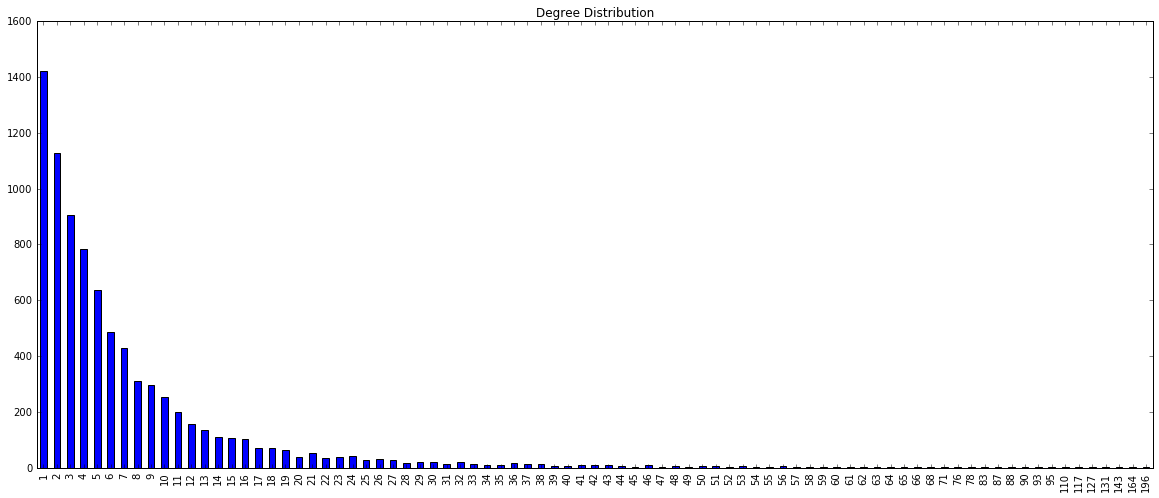

In [25]:
##### OUTPUT FOR HW7.1 DEGREE DISTRIBUTION #####
%matplotlib inline
import pandas

# Initialize a dictionary to store the lengths and frequencies
#len_freq = {}
#filename = 'EDALengthCount_results.text'
#with open(filename, 'r') as f:
#    for line in f.readlines():
#        key,value =  line.strip().split('\t',2)
#        len_freq[int(key)] = int(value)

#http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

# Plot a histogram of the lengths and their frequencies
df = pandas.DataFrame.from_dict(degree_dist, orient='index')
df = df.sort_index()
df.plot(kind='bar', figsize=(20,8), legend=False, 
        title='Degree Distribution')

<h1 style="color:#021353;">HW 7.2: Shortest path graph distances (NLTK synonyms)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

=====================================
<strong>NOTE: Dataset 2 English Wikipedia hyperlink network.data </strong>
The dataset is available via Dropbox at:

https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

on S3 at 
<a href="s3://ucb-mids-mls-networks/wikipedia/">s3://ucb-mids-mls-networks/wikipedia/</a>
<a href="s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt">s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt</a> # Graph
<a href="s3://ucb-mids-mls-networks/wikipedia/indices.txt">s3://ucb-mids-mls-networks/wikipedia/indices.txt</a> # Page titles and page Ids

For the remainder of this assignment you will explore the English Wikipedia hyperlink network.

The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

Data: <a href="s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt">s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt</a>
Data: <a href="s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt">s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt</a>
Data: <a href="s3://ucb-mids-mls-networks/wikipedia/indices.txt">s3://ucb-mids-mls-networks/wikipedia/indices.txt</a>

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.

</pre>
</div>

Shortest path is:  "7827->1426->4652->536"

In [39]:
%reload_ext autoreload
%autoreload 2
from SSSPInit import MRSSSPInit

work_filename = 'work_table.txt'
mr_job = MRSSSPInit(args=['synNet.txt', '--start_index', '7827'])
#mr_job = MRSSSPInit(args=['synNet_100.txt', '--start_index', '10'])
#mr_job = MRSSSPInit(args=['synNet_20.txt', '--start_index', '10'])

with mr_job.make_runner() as runner, open(work_filename, 'w') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key, value =  mr_job.parse_output_line(line)
        f.write(value)

In [40]:
%reload_ext autoreload
%autoreload 2
from SSSP import MRSSSP

work_filename = 'work_table.txt'

# Run the SSSP MRJob
mr_job = MRSSSP(args=[work_filename])
    
# Update centroids iteratively
i = 0
not_all_visited = True
while(not_all_visited):
#while(i<10):
    work_table = {}
    not_all_visited = False
    print('Iteration %d' % (i))
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            #print key, value
            work_table[key] = value
            if value[3] in 'Q':
                not_all_visited = True 
        
        # Update work_table for the next iteration
        with open(work_filename, 'w') as f:
            for key, value in work_table.iteritems():
                f.write(key)
                f.writelines('\t'+str(v) for v in value)
                f.write('\n')
    i += 1

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


In [44]:
# Store the results in a file called 'work_table7-2.txt'
#!mv work_table.txt work_table7-2.txt
!head -1 work_table7-2.txt
!grep '536	' work_table7-2.txt

3382	{u'4909': 1, u'3383': 1, u'3381': 1}	inf		U
3536	{u'1436': 1, u'1437': 1, u'769': 1, u'1438': 1, u'1865': 1, u'1864': 1, u'1870': 1, u'1869': 1, u'402': 1}	5.0	7827->1426->1495->405->402->3536	V
2536	{u'2622': 1, u'4058': 1, u'2621': 1, u'156': 1, u'3399': 1, u'1192': 1, u'3947': 1, u'617': 1, u'2609': 1, u'5461': 1, u'2533': 1, u'137': 1, u'5336': 1, u'2947': 1, u'226': 1, u'268': 1, u'1150': 1, u'4010': 1}	4.0	7827->1426->1706->137->2536	V
5536	{u'1704': 1, u'5535': 1, u'5957': 1, u'2771': 1, u'2195': 1, u'3520': 1, u'5961': 1, u'5963': 1, u'95': 1, u'5967': 1, u'1699': 1}	3.0	7827->1426->1699->5536	V
536	{u'215': 1, u'264': 1, u'662': 1, u'3658': 1, u'3656': 1, u'3657': 1, u'3651': 1, u'3652': 1, u'3653': 1, u'3555': 1, u'3554': 1, u'6002': 1, u'3552': 1, u'6000': 1, u'6001': 1, u'404': 1, u'2248': 1, u'2249': 1, u'3750': 1, u'2246': 1, u'2247': 1, u'3993': 1, u'3992': 1, u'3760': 1, u'3761': 1, u'1313': 1, u'3481': 1, u'3769': 1, u'3483': 1, u'3482': 1, u'3485': 1, u'121': 1, 

<h1 style="color:#021353;">HW 7.3: Exploratory data analysis (Wikipedia)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 

Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 

This means that you may have to ADJUST your code (depending on its design). 

To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.
</pre>
</div>

In [22]:
#!cd /data
#!wget http://ucb-mids-mls-networks.s3.amazonaws.com/wikipedia/all-pages-indexed-out.txt
#!wget http://ucb-mids-mls-networks.s3.amazonaws.com/wikipedia/all-pages-indexed-in.txt
#!wget http://ucb-mids-mls-networks.s3.amazonaws.com/wikipedia/indices.txt
#!cd /home/hadoop/w261-Assignments/hw7

In [42]:
#!hdfs dfs -mkdir /user/hadoop/HW7data
#!hdfs dfs -mkdir /user/hadoop/HW7Results
#!hdfs dfs -mkdir /user/hadoop/HW7Output
#!hdfs dfs -copyFromLocal /data/indices.txt /user/hadoop/HW7data
#!hdfs dfs -copyFromLocal /data/all-pages-indexed-in.txt /user/hadoop/HW7data
#!hdfs dfs -copyFromLocal /data/all-pages-indexed-out.txt /user/hadoop/HW7data
#!hdfs dfs -copyFromLocal synNet.txt /user/hadoop/HW7data

16/07/05 00:46:31 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/05 00:46:34 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [35]:
%%writefile EDADirectedGraph.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import Counter
import ast

class MREDADirectedGraph(MRJob):
    def __init__(self, *args, **kwargs):
        super(MREDADirectedGraph, self).__init__(*args, **kwargs)
        self.total_nodes = 0
        self.total_edges = 0
        
    #load data and output the nearest centroid index and data point plus a count of 1. 
    def mapper(self, _, line):
        node_num, adj_dict = line.strip().split('\t')
        adj_dict = ast.literal_eval(adj_dict)
        yield '**' + node_num, 1
        for node in adj_dict:
            yield '**' + node, 1
        degree = len(adj_dict)
        yield str(degree), 1
        self.total_edges += degree
    
    def mapper_final(self):
        yield '*total_edges', self.total_edges
    
    def combiner(self, key, data):
        yield key, sum(data)
    
    #Aggregate sum for each cluster and then calculate the new centroids
    def reducer(self, key, data):
        if key[:2] == '**':
            self.total_nodes += 1
        elif key == '*total_edges':
            yield '*total_nodes', self.total_nodes
            self.total_edges = float(sum(data))
            yield key, self.total_edges
        else:
            yield key, sum(data)

    def steps(self):
        # Create the steps for the MRJob.  There is only one MRJob here containing
        # a mapper, a combiner and a reducer.
        JOBCONF_STEP = {        
            'mapreduce.job.maps': '100',
            'mapreduce.job.reduces': '1'
        }
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper=self.mapper, mapper_final=self.mapper_final,
                   combiner=self.combiner,
                   reducer=self.reducer)
               ]
            
if __name__ == '__main__':
    MREDADirectedGraph.run()

Overwriting EDADirectedGraph.py


In [44]:
%reload_ext autoreload
%autoreload 2
from EDADirectedGraph import MREDADirectedGraph

# Run the KMeans MRJob
#mr_job = MREDADirectedGraph(args=['synNet_100.txt'])
#mr_job = MREDADirectedGraph(args=['synNet.txt'])
#mr_job = MREDADirectedGraph(args=['synNet.txt', '-r', 'hadoop'])
ofile ='HW7Output/EDADirectedGraph'
!hdfs dfs -rm -r /user/hadoop/$ofile
mr_job = MREDADirectedGraph(args=['hdfs:///user/hadoop/HW7data/synNet.txt', '-r', 'hadoop', '--output-dir', ofile])
#mr_job = MREDADirectedGraph(args=['hdfs:///user/hadoop/HW7data/all-pages-indexed-out.txt', '-r', 'hadoop'])

degree_dist = {}
total_unique_nodes = 0
total_edges = 0
with mr_job.make_runner() as runner: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key, value =  mr_job.parse_output_line(line)
        #print key, value
        if key == '*total_nodes':
            total_unique_nodes += value
        elif key == '*total_edges':
            total_edges += value
        else:
            degree_dist[int(key)] = value

print('Total Nodes: %d' % (total_unique_nodes))
print('Total Edges Directed: %.2f' % (total_edges))
print('Total Edges Undirected: %.2f' % (total_edges/2.0))
print('Average Degree: %.2f' % (total_edges/total_unique_nodes))
print len(degree_dist)
print degree_dist

16/07/05 00:52:15 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `/user/hadoop/HW7Output/EDADirectedGraph': No such file or directory


ERROR:mrjob.fs.hadoop:STDERR: 16/07/05 00:54:23 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



Total Nodes: 8271
Total Edges Directed: 61134.00
Total Edges Undirected: 30567.00
Average Degree: 7.39
83
{68: 3, 1: 1421, 2: 1127, 131: 1, 4: 783, 5: 637, 6: 488, 7: 429, 8: 309, 9: 296, 10: 254, 11: 200, 12: 158, 13: 135, 14: 111, 143: 2, 16: 104, 17: 70, 18: 70, 19: 62, 20: 39, 21: 51, 22: 34, 23: 40, 24: 42, 25: 26, 26: 31, 27: 26, 28: 17, 29: 21, 30: 20, 31: 14, 32: 21, 33: 14, 34: 11, 35: 10, 164: 1, 37: 13, 38: 13, 39: 7, 40: 6, 41: 8, 42: 8, 43: 10, 44: 7, 45: 4, 46: 8, 47: 2, 48: 5, 49: 4, 50: 5, 51: 7, 52: 3, 53: 6, 54: 2, 55: 4, 56: 5, 57: 3, 58: 2, 59: 3, 60: 2, 61: 2, 62: 3, 63: 1, 64: 1, 65: 2, 66: 2, 196: 1, 71: 1, 76: 2, 78: 2, 83: 1, 87: 1, 88: 1, 36: 15, 90: 1, 15: 108, 93: 1, 95: 1, 3: 906, 110: 2, 117: 1, 127: 1}


In [53]:
#!hdfs dfs -cat $ofile/part-00000 | head -20
#!hdfs dfs -cp $ofile/part-00000 /user/hadoop/HW7Results/synNet_EDA.txt
#!hdfs dfs -cat /user/hadoop/HW7Results/synNet_EDA.txt | head -20
#!hdfs dfs -copyToLocal $ofile/part-00000 wikipedia_EDA.txt
#!hdfs dfs -copyToLocal /user/hadoop/HW7Results/synNet_EDA.txt synNet_EDA.txt

16/07/05 01:55:15 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/05 01:55:16 WARN hdfs.DFSClient: DFSInputStream has been closed already


Total Nodes: 15192277
Total Edges Directed: 142114057.00
Total Edges Undirected: 71057028.50
Average Degree: 9.35
2062
{1: 869993, 2: 123110, 3: 160376, 4: 174474, 5: 191640, 6: 193050, 7: 201193, 8: 232863, 9: 215577, 10: 193438, 11: 186724, 12: 178481, 13: 211048, 14: 145958, 15: 134809, 16: 122792, 17: 113188, 18: 104479, 19: 97760, 20: 91767, 21: 86038, 22: 80052, 23: 75382, 24: 70876, 25: 66873, 26: 62577, 27: 58612, 28: 54757, 29: 51875, 30: 49193, 31: 46219, 32: 44474, 33: 41568, 34: 39023, 35: 36503, 36: 33887, 37: 32495, 38: 30612, 39: 29248, 40: 27655, 41: 26173, 42: 25111, 43: 24037, 44: 22626, 45: 21350, 46: 20572, 47: 19603, 48: 18922, 49: 17985, 50: 17257, 51: 16724, 52: 15714, 53: 15089, 54: 14613, 55: 14010, 56: 13623, 57: 12718, 58: 12652, 59: 12156, 60: 11525, 61: 11151, 62: 10746, 63: 10431, 64: 10249, 65: 9784, 66: 9277, 67: 9066, 68: 8760, 69: 8368, 70: 8048, 71: 7760, 72: 7517, 73: 7350, 74: 7043, 75: 6866, 76: 6727, 77: 6510, 78: 6257, 79: 6204, 80: 5978, 81: 584

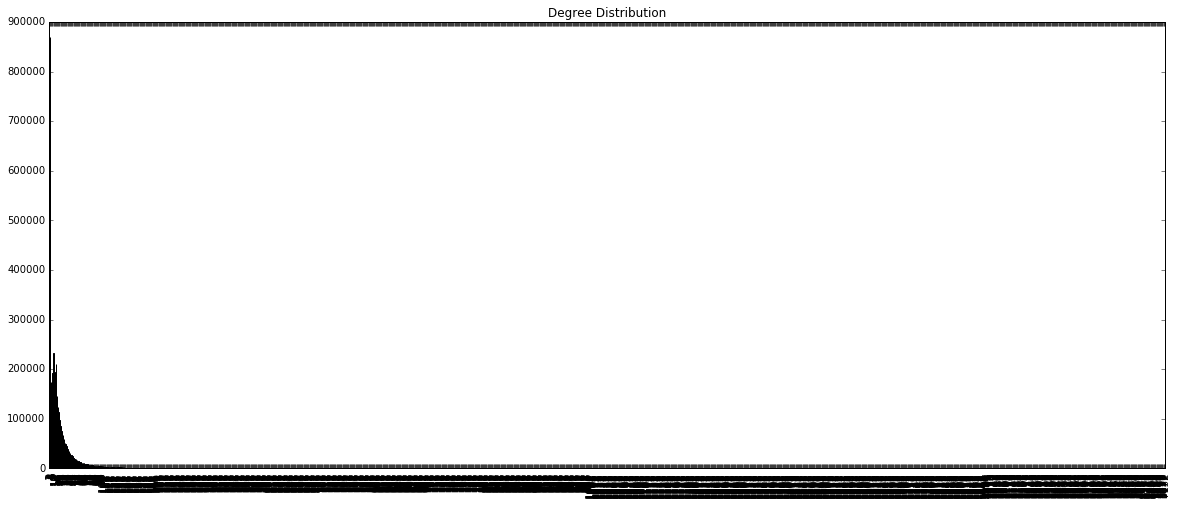

In [59]:
##### OUTPUT FOR HW5.3 5-GRAM LENGTH DISTRIBUTIONS #####
%matplotlib inline
import pandas

# Initialize a dictionary to store the lengths and frequencies
degree_dist = {}
#filename = 'synNet_EDA.txt'
filename = 'wikipedia_EDA.txt'
with open(filename, 'r') as f:
    for line in f.readlines():
        key,value =  line.strip().split('\t',2)
        key = key.strip('"')
        if key == '*total_nodes':
            total_unique_nodes = int(value)
        elif key == '*total_edges':
            total_edges = float(value)
        else:
            degree_dist[int(key)] = int(value)

print('Total Nodes: %d' % (total_unique_nodes))
print('Total Edges Directed: %.2f' % (total_edges))
print('Total Edges Undirected: %.2f' % (total_edges/2.0))
print('Average Degree: %.2f' % (total_edges/total_unique_nodes))
print len(degree_dist)
print degree_dist

#http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

# Plot a histogram of the lengths and their frequencies
df = pandas.DataFrame.from_dict(degree_dist, orient='index')
df = df.sort_index()
df.plot(kind='bar', figsize=(20,8), legend=False, 
        title='Degree Distribution')

<h1 style="color:#021353;">HW 7.4: Shortest path graph distances (Wikipedia)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output. Show the shortest path in terms of just page IDS but also in terms of the name of page (show of your MapReduce join skills!!)

Once your code is running, find some other shortest paths and report your results.
</pre>
</div>

In [26]:
!hdfs dfs -copyFromLocal directed_toy.txt /user/hadoop/HW7data

16/07/05 21:36:24 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [107]:
%reload_ext autoreload
%autoreload 2
from SSSPInit import MRSSSPInit

work_filename = 'work_table.txt'
ofile ='HW7Output/SSSPInit'
!hdfs dfs -rm -r /user/hadoop/$ofile
mr_job = MRSSSPInit(args=['hdfs:///user/hadoop/HW7data/synNet.txt', '-r', 'hadoop', '--start_index=7827', '--output-dir', ofile])
#mr_job = MRSSSPInit(args=['hdfs:///user/hadoop/HW7data/directed_toy.txt', '-r', 'hadoop', '--output-dir', ofile])
#mr_job = MRSSSPInit(args=['synNet.txt', '--start_index', '7827'])
#mr_job = MRSSSPInit(args=['synNet_100.txt', '--start_index', '10'])
#mr_job = MRSSSPInit(args=['synNet_20.txt', '--start_index', '10'])

with mr_job.make_runner() as runner, open(work_filename, 'w') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key, value =  mr_job.parse_output_line(line)
        print key, value
        f.write(key+'\t'+json.dumps(value)+'\n')
        #f.write(key+'\t'+str(value)+'\n')
    print(runner.counters())

16/07/05 22:59:36 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/05 22:59:37 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/HW7Output/SSSPInit


1 [{u'3': 1, u'2': 1, u'4': 1}, inf, u'', u'U']
2 [{u'1': 1, u'3': 1, u'310': 1, u'4': 1, u'311': 1}, inf, u'', u'U']
3 [{u'1': 1, u'2': 1, u'4': 1}, inf, u'', u'U']
4 [{u'1': 1, u'3': 1, u'2': 1, u'311': 1}, inf, u'', u'U']
5 [{u'6': 1}, inf, u'', u'U']
6 [{u'5': 1}, inf, u'', u'U']
7 [{u'9': 1, u'8': 1}, inf, u'', u'U']
8 [{u'9': 1, u'7': 1}, inf, u'', u'U']
9 [{u'8': 1, u'124': 1, u'7': 1, u'1316': 1}, inf, u'', u'U']
10 [{u'11': 1, u'13': 1, u'12': 1, u'15': 1, u'14': 1, u'17': 1, u'16': 1}, inf, u'', u'U']
11 [{u'605': 1, u'10': 1, u'13': 1, u'12': 1, u'15': 1, u'14': 1, u'17': 1, u'16': 1, u'4035': 1, u'4034': 1, u'4037': 1, u'4036': 1, u'4039': 1, u'4038': 1}, inf, u'', u'U']
12 [{u'11': 1, u'10': 1, u'13': 1, u'16': 1, u'2209': 1, u'1168': 1, u'3633': 1, u'4240': 1, u'4241': 1, u'4035': 1, u'4034': 1, u'4037': 1, u'4557': 1, u'4039': 1, u'4038': 1, u'3052': 1}, inf, u'', u'U']
13 [{u'11': 1, u'10': 1, u'12': 1, u'4039': 1, u'16': 1}, inf, u'', u'U']
14 [{u'605': 1, u'10': 1, u'

ERROR:mrjob.fs.hadoop:STDERR: 16/07/05 23:00:09 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



[{u'113': 1, u'105': 1}, inf, u'', u'U']
2732 [{u'690': 1, u'689': 1, u'688': 1}, inf, u'', u'U']
2733 [{u'2595': 1, u'2596': 1, u'2597': 1, u'948': 1, u'1996': 1, u'414': 1, u'953': 1, u'949': 1, u'2598': 1, u'1537': 1, u'654': 1, u'1316': 1, u'828': 1, u'1450': 1, u'992': 1}, inf, u'', u'U']
2734 [{u'393': 1, u'399': 1}, inf, u'', u'U']
2735 [{u'2736': 1, u'2737': 1, u'406': 1, u'2738': 1, u'2739': 1, u'462': 1, u'2741': 1, u'2740': 1, u'2742': 1}, inf, u'', u'U']
2736 [{u'2735': 1, u'4274': 1, u'2738': 1, u'2739': 1, u'5026': 1, u'462': 1}, inf, u'', u'U']
2737 [{u'2735': 1, u'2827': 1, u'2740': 1, u'3034': 1, u'4122': 1, u'4121': 1, u'4120': 1, u'2739': 1, u'2741': 1, u'5521': 1, u'2742': 1, u'4993': 1, u'4123': 1, u'2758': 1, u'4119': 1}, inf, u'', u'U']
2738 [{u'2735': 1, u'2736': 1, u'4274': 1, u'2739': 1, u'5026': 1, u'462': 1}, inf, u'', u'U']
2739 [{u'2735': 1, u'2736': 1, u'2737': 1, u'4274': 1, u'3034': 1, u'2738': 1, u'4186': 1, u'2741': 1, u'406': 1, u'462': 1, u'2742': 1

ERROR:mrjob.fs.hadoop:STDERR: 16/07/05 23:00:12 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



8261 [{u'8262': 1}, inf, u'', u'U']
8262 [{u'8261': 1}, inf, u'', u'U']
8263 [{u'5000': 1}, inf, u'', u'U']
8264 [{u'8265': 1}, inf, u'', u'U']
8265 [{u'8264': 1}, inf, u'', u'U']
8266 [{u'4203': 1}, inf, u'', u'U']
8267 [{u'8268': 1}, inf, u'', u'U']
8268 [{u'8267': 1}, inf, u'', u'U']
8269 [{u'8270': 1}, inf, u'', u'U']
8270 [{u'8269': 1}, inf, u'', u'U']
8271 [{u'3467': 1}, inf, u'', u'U']
[{'File System Counters': {'FILE: Number of write operations': 0, 'HDFS: Number of write operations': 4, 'FILE: Number of read operations': 0, 'HDFS: Number of bytes read': 709193, 'HDFS: Number of read operations': 10, 'FILE: Number of bytes written': 239450, 'HDFS: Number of large read operations': 0, 'HDFS: Number of bytes written': 895526, 'FILE: Number of large read operations': 0, 'FILE: Number of bytes read': 0}, 'Job Counters ': {'Total time spent by all maps in occupied slots (ms)': 7453, 'Total vcore-seconds taken by all map tasks': 7453, 'Launched map tasks': 2, 'Rack-local map tasks': 

In [144]:
#!hdfs dfs -mkdir /user/hadoop/HW7Input
#!hdfs dfs -cp /user/hadoop/HW7Output/SSSPInit /user/hadoop/HW7Input/SSSPInit
#!hdfs dfs -rm -r /user/hadoop/HW7Results/SSSPInit_synNet
#!hdfs dfs -cp /user/hadoop/HW7Output/SSSPInit /user/hadoop/HW7Results/SSSPInit_synNet
#!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_d_toy/part-00001

#!hdfs dfs -cp /user/hadoop/HW7Output/SSSPInit /user/hadoop/HW7Results/SSSPInit_wikipedia
#!hdfs dfs -cat /user/hadoop/HW7Output/SSSPInit/part-00001 | head -5

#!hdfs dfs -rm -r /user/hadoop/HW7Results/SSSPInit_d_toy
#!hdfs dfs -cp /user/hadoop/HW7Output/SSSPInit /user/hadoop/HW7Results/SSSPInit_d_toy
#!hdfs dfs -ls /user/hadoop/HW7Output/SSSPInit
#!hdfs dfs -ls /user/hadoop/HW7Results/SSSPInit_synNet
#!hdfs dfs -cat /user/hadoop/HW7Output/SSSPInit/part-00000 | head -5
#!hdfs dfs -copyToLocal /user/hadoop/HW7Output/SSSPInit/part-00001 SSSP_d_toy2.txt

16/07/06 00:38:40 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/06 00:38:41 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/07/06 00:38:44 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/07/06 00:38:45 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/07/06 00:38:47 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/07/06 00:38:48 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/07/06 00:38:50 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/07/06 00:38:53 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/07/06 00:38:55 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/07/06 00:38:56 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/07/06 00:38:58 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/07/06 00:39:00 WARN hdfs.DFSClient: DFSInputStream has been closed al

In [145]:
ofile ='HW7Output/SSSPInit'
!hdfs dfs -cat $ofile/part-00000 | grep Q
!hdfs dfs -cat $ofile/part-00001 | grep Q
!hdfs dfs -cat $ofile/part-00002 | grep Q
!hdfs dfs -cat $ofile/part-00003 | grep Q
!hdfs dfs -cat $ofile/part-00004 | grep Q
!hdfs dfs -cat $ofile/part-00005 | grep Q
!hdfs dfs -cat $ofile/part-00006 | grep Q
!hdfs dfs -cat $ofile/part-00007 | grep Q
!hdfs dfs -cat $ofile/part-00008 | grep Q
!hdfs dfs -cat $ofile/part-00009 | grep Q
!hdfs dfs -cat $ofile/part-00010 | grep Q
!hdfs dfs -cat $ofile/part-00011 | grep Q
!hdfs dfs -cat $ofile/part-00012 | grep Q
!hdfs dfs -cat $ofile/part-00013 | grep Q
!hdfs dfs -cat $ofile/part-00014 | grep Q
!hdfs dfs -cat $ofile/part-00015 | grep Q
!hdfs dfs -cat $ofile/part-00000 | head
#!hdfs dfs -cat $ofile/part-00001 | head
#!cat work_table_init_synNet.txt | head
#!hdfs dfs -cat $ofile/part-00001 | grep Q
#!hdfs dfs -cp $ofile/part-00000 /user/hadoop/HW7Results/synNet_EDA.txt
#!hdfs dfs -cat /user/hadoop/HW7Results/synNet_EDA.txt | head -20
#!hdfs dfs -copyToLocal $ofile/part-00000 wikipedia_EDA.txt
#!hdfs dfs -copyToLocal /user/hadoop/HW7Results/synNet_EDA.txt synNet_EDA.txt

16/07/06 00:40:44 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/06 00:40:48 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/06 00:40:51 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/06 00:40:54 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/06 00:40:58 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/06 00:41:01 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/06 00:41:04 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using bu

In [20]:
print(369906+374353+372948+369808+367461+364305+370867+373471+371803+369771+372389+370621+372097+374391+369104+217995)
#!hdfs dfs -cat $ofile/part-00015 | grep Q

5781290
16/07/05 12:00:02 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [30]:
s = "73\t{'14417532': 1}\tinf\t\tU"
s = s.strip('"')
print s

73	{'14417532': 1}	inf		U


In [34]:
#!hdfs dfs -cat /user/hadoop/HW7Input/SSSP/part-00000 | head -10
!hdfs dfs -copyToLocal hdfs:///user/hadoop/HW7Input/SSSP/part-00000 SSSP_synNet1.txt
!hdfs dfs -copyToLocal hdfs:///user/hadoop/HW7Input/SSSP/part-00001 SSSP_synNet2.txt

16/07/05 13:29:49 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/05 13:29:50 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/07/05 13:29:52 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/05 13:29:53 WARN hdfs.DFSClient: DFSInputStream has been closed already


In [5]:
#!hdfs dfs -rm -r /user/hadoop/HW7Input/SSSP
#!hdfs dfs -cp /user/hadoop/HW7Results/SSSPInit_synNet /user/hadoop/HW7Input/SSSP
#!hdfs dfs -ls /user/hadoop/HW7Input/SSSP
#!hdfs dfs -mkdir /user/hadoop/TestDir
#!hdfs dfs -mv /user/hadoop/HW7Input/SSSP /user/hadoop/TestDir
#!hdfs dfs -ls /user/hadoop/TestDir
!hdfs dfs -cat /user/hadoop/HW7Input/SSSP/part-00000 | head -5
!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_synNet/part-00000 | head -5

16/07/05 16:54:34 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"1"	[{"3": 1, "2": 1, "4": 1}, Infinity, "", "U"]
"10"	[{"11": 1, "13": 1, "12": 1, "15": 1, "14": 1, "17": 1, "16": 1}, Infinity, "", "U"]
"100"	[{"3827": 1, "2872": 1, "2871": 1, "2870": 1, "2875": 1, "2874": 1, "617": 1, "2441": 1, "5550": 1, "5336": 1, "93": 1, "92": 1, "3720": 1, "3722": 1, "2873": 1, "3122": 1, "2443": 1, "4647": 1, "360": 1}, Infinity, "", "U"]
"1000"	[{"997": 1, "1003": 1, "1004": 1, "999": 1, "1002": 1, "1001": 1}, Infinity, "", "U"]
"1001"	[{"997": 1, "999": 1, "998": 1, "1000": 1}, Infinity, "", "U"]
cat: Unable to write to output stream.
16/07/05 16:54:36 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
null	"1\t{'2': 1, '3': 1, '4': 1}\tinf\t\tU"
null	"2\t{'1': 1, '3': 1, '4': 1, '310': 1, '311': 1}\tinf\t\tU"
null	"3\t{'1': 1, '2'

In [146]:
%%writefile SSSP_driver.py
#%reload_ext autoreload
#%autoreload 2
from SSSP import MRSSSP
import subprocess

# Run the SSSP MRJob
#subprocess.check_call(["ls", "-l"])
#!hdfs dfs -rm -r /user/hadoop/HW7Output/SSSP
try:
    subprocess.check_call(['hdfs', 'dfs', '-rm', '-r', '/user/hadoop/HW7Output/SSSP'])
except:
    pass
#!hdfs dfs -rm -r /user/hadoop/HW7Input/SSSP
try:
    subprocess.check_call(['hdfs', 'dfs', '-rm', '-r', '/user/hadoop/HW7Input/SSSP'])
except:
    pass
#!hdfs dfs -cp /user/hadoop/HW7Results/SSSPInit_synNet /user/hadoop/HW7Input/SSSP
#subprocess.check_call(['hdfs', 'dfs', '-cp', '/user/hadoop/HW7Results/SSSPInit_synNet', '/user/hadoop/HW7Input/SSSP'])
#!hdfs dfs -cp /user/hadoop/HW7Results/SSSPInit_d_toy /user/hadoop/HW7Input/SSSP
#subprocess.check_call(['hdfs', 'dfs', '-cp', '/user/hadoop/HW7Results/SSSPInit_d_toy', '/user/hadoop/HW7Input/SSSP'])
#!hdfs dfs -cp /user/hadoop/HW7Results/SSSPInit_wikipedia /user/hadoop/HW7Input/SSSP
subprocess.check_call(['hdfs', 'dfs', '-cp', '/user/hadoop/HW7Results/SSSPInit_wikipedia', '/user/hadoop/HW7Input/SSSP'])
mr_job = MRSSSP(args=['hdfs:///user/hadoop/HW7Input/SSSP', '-r', 'hadoop', '--output-dir', 'HW7Output/SSSP', '--no-output'])
    
# Update work table file iteratively
i = 0
# Set start condition to True
not_all_visited = True
while(not_all_visited):
    # Set start condition to False
    not_all_visited = False
    # Print the iteration number
    print('Iteration %d' % (i))
    with mr_job.make_runner() as runner: 
        runner.run()
        if 'SSSP_Counters' in runner.counters()[0]:
            not_all_visited = True
    if not_all_visited:
        #!hdfs dfs -rm -r /user/hadoop/HW7Input/SSSP
        subprocess.check_call(['hdfs', 'dfs', '-rm', '-r', '/user/hadoop/HW7Input/SSSP'])
        #!hdfs dfs -mv '/user/hadoop/HW7Output/SSSP , '/user/hadoop/HW7Input/SSSP
        subprocess.check_call(['hdfs', 'dfs', '-mv', '/user/hadoop/HW7Output/SSSP', '/user/hadoop/HW7Input/SSSP'])
    i += 1

Overwriting SSSP_driver.py


In [134]:
#!hdfs dfs -rm -r /user/hadoop/HW7Output/SSSP
!hdfs dfs -ls /user/hadoop/HW7Output/SSSP
#!hdfs dfs -cat /user/hadoop/HW7Output/SSSP/part-00000 | grep ">536"
#!hdfs dfs -cp /user/hadoop/HW7Output/SSSP/part-00000 /user/hadoop/HW7Results/synNet_SSSP.text

#!hdfs dfs -ls /user/hadoop/HW7Results/SSSPInit_synNet
#!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_synNet/part-00000 | head -3
#!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_synNet/part-00001 | grep Q

#!hdfs dfs -ls /user/hadoop/HW7Results/SSSPInit_d_toy
#!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_d_toy/part-00000
#!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_d_toy/part-00001

#!hdfs dfs -ls /user/hadoop/HW7Input/SSSP
#!hdfs dfs -cat /user/hadoop/HW7Input/SSSP/part-00000 | head -3
#!hdfs dfs -cat /user/hadoop/HW7Input/SSSP/part-00000 | grep Q
#!hdfs dfs -copyToLocal /user/hadoop/HW7Input/SSSP/part-00001 SSSP_d_toy_iter1b.txt

16/07/06 00:19:01 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   3 hadoop supergroup          0 2016-07-06 00:07 /user/hadoop/HW7Output/SSSP/_SUCCESS
-rw-r--r--   3 hadoop supergroup    1072794 2016-07-06 00:07 /user/hadoop/HW7Output/SSSP/part-00000


In [54]:
import commands
hc = commands.getoutput('hdfs dfs -cp /user/hadoop/HW7Output/SSSP /user/hadoop/HW7Input/SSSP')
hc = commands.getoutput('!hdfs dfs -rm -r /user/hadoop/HW7Output/')
hdir_list = commands.getoutput('hdfs dfs -ls /user/hadoop/HW7Input/SSSP')
print(hdir_list)

16/07/05 13:53:40 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 3 items
drwxr-xr-x   - hadoop supergroup          0 2016-07-05 13:53 /user/hadoop/HW7Input/SSSP/SSSP
-rw-r--r--   3 hadoop supergroup     402512 2016-07-05 13:07 /user/hadoop/HW7Input/SSSP/part-00000
-rw-r--r--   3 hadoop supergroup     451669 2016-07-05 13:07 /user/hadoop/HW7Input/SSSP/part-00001


In [55]:
!hdfs dfs -ls /user/hadoop/HW7Input/SSSP

16/07/05 13:54:48 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 3 items
drwxr-xr-x   - hadoop supergroup          0 2016-07-05 13:53 /user/hadoop/HW7Input/SSSP/SSSP
-rw-r--r--   3 hadoop supergroup     402512 2016-07-05 13:07 /user/hadoop/HW7Input/SSSP/part-00000
-rw-r--r--   3 hadoop supergroup     451669 2016-07-05 13:07 /user/hadoop/HW7Input/SSSP/part-00001


<h1 style="color:#021353;">HW 7.5: Conceptual exercise: Largest single-source network distances</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source.

How would you implement this task? 
How is this different from finding the shortest path graph distances?

Is this task more difficult to implement than the shortest path distance?

As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...
</pre>
</div>

<h1 style="color:#021353;">HW 7.5.1: </h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Can we utilize combiners in the HW 7 to perform the shortest path implementation?
Does order inversion help with the HW 7 shortest path implementation?
</pre>
</div>

<h1 style="color:#021353;">HW 7.5.2: OPTIONAL </h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Implement combiners in the context of HW 7.5 and contrast the performance of this implementation versus the implementation with no combiners. 

Please report the cluster configuration and runtimes in tabular format for both experiments and comment on your findings.
</pre>
</div>

<h1 style="color:#021353;">HW 7.6: Computational exercise: Largest single-source network distances: OPTIONAL </h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Using MRJob, write a code to find the largest graph distance and distance-maximizing nodes from a single-source.
Test your code first on the toy networks and synonyms network to proof its function.
</pre>
</div>

==================END HW 7==================

In [2]:
import ast
#import json

with open("SSSP_synNet.txt", 'r') as f:
    s = f.readline()
    s1, s2 = s.strip().split('\t')
    s1 = s1.strip('"')
    x2 = json.loads(s2)
    #s2 = ast.literal_eval(s2)
    #s3, s4, s5 = s2.split(',')
    print s1
    print x2
    print x2[0] # this is a dict
    print x2[1] # this is a float
    print x2[2] # this is unicode
    print x2[3] # this is unicode

1
[{u'3': 1, u'2': 1, u'4': 1}, inf, u'', u'U']
{u'3': 1, u'2': 1, u'4': 1}
inf

U
